In [22]:
# <!-- collapse=True -->
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', size=12)
plt.rc('axes', labelsize=12)

# Régression linéaire, est-ce que c'est aussi simple ?

Lecture du chapitre 16 du livre _Probabilités, analyses des données et Statistique_, de _Gilbert Saporta_.

## Méthode des moindres carrés
La méthode la plus célèbre est bien sûr la méthode des moindres carrés. On recherche la droite $y^\star(x)$ tel que:

$$
y^\star - \bar y = a \, ( x - \bar x )
$$
où $\bar x$ et $\bar y$ sont les moyennes (estimées). 

La pente $a$ est obtenue par la formule analytique:
$$
a  = \frac{ \Sigma (y_i - \bar y) (x_i - \bar x) }{ \Sigma (x_i - \bar x)^2 }
$$


In [23]:
def moindrescarres(X, Y):
    xm, ym = np.mean( X ), np.mean( Y )
    
    a = np.sum( (Y-ym)*(X-xm) )/np.sum( (X-xm)**2 )
    b = ym - a*xm
    
    return a, b

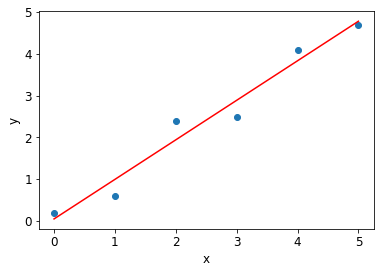

In [24]:
# <!-- collapse=True -->
X = np.array( [ 0, 1, 2, 3, 4, 5 ] )
Y = np.array( [ .2, .6, 2.4, 2.5, 4.1, 4.7 ] )

a, b = moindrescarres(X, Y)

plt.plot( X, Y, "o" );
plt.plot( X, a*X + b , 'r'  );
plt.xlabel('x');plt.ylabel('y');

_Questions possibles:_ quel est l'intervalle de confiance, écart-type, de la pente ?

## Est-ce que la méthode des moindres carrés est toujours la mieux ?
Pas forcement: La méthode des moindres carrés est sensible aux valeurs abérrantes...

Par exemple, minimiser la somme des **valeurs absolues** reduit cette dépendance. Il n'existe pas, dans ce cas, de formule analytique pour calculer pente de la droite. Une méthode d'optimisation numérique par itération doit donc être utilisée.


_Remarque:_ voir forum [carré vs v. abolue ?](http://www.les-mathematiques.net/phorum/read.php?13,404999)

In [25]:
from scipy import optimize

def regressionL(X, Y):
    costfun = lambda P: np.sum( np.abs( Y - (P[0]*X+P[1]) ) )
    Pzero = moindrescarres(X, Y)
    r = optimize.minimize(costfun, Pzero)
    return r.x

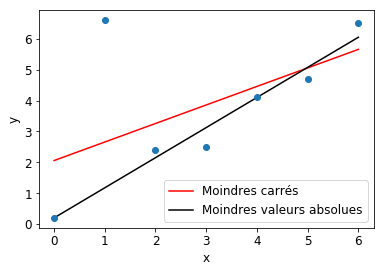

In [77]:
# <!-- collapse=True -->

X = np.array( [ 0, 1, 2, 3, 4, 5, 6 ] )
Y = np.array( [ .2, 6.6, 2.4, 2.5, 4.1, 4.7, 6.5 ] )

a, b = moindrescarres(X, Y)
plt.plot( X, a*X + b , '-r', label='Moindres carrés'  );

a, b = regressionL(X, Y)
plt.plot( X, a*X + b , 'k' , label='Moindres valeurs absolues' );

plt.plot( X, Y, "o" );
plt.legend(); plt.xlabel('x'); plt.ylabel('y');

## Corrélation des résidus ?

On peut se demander comment évaluer la justesse de la regression. Est-ce la droite obtenue est un bon modèle des données ? Une première mesure est le coefficient de corrélation (de Pearson) entre $y$ et $x$. Au second ordre, on peut s'interesser aux propriétés statistiques des résidus ($R = y - y^\star$).

Les résidus issus d'une regression sont idéalement un bruit, de moyenne nulle, et non correllés temporellement. Une manière de vérifier ce dernier point est de tracer l'autocorrélation. Plus simplement, on peut étudier la corrélation entre le residu au temps $t$ et celui au temps $t-1$.

In [71]:
X = np.linspace(0, 1, 20)

Y0 = 2*np.sin( X*12 ) + 15*X
Y =  Y0 + np.random.normal(loc=0.0, scale=1.0, size=len(X))

In [72]:
a, b = moindrescarres(X, Y)
Ymc = a*X + b

# Calcul des résidus:
R = Y - Ymc

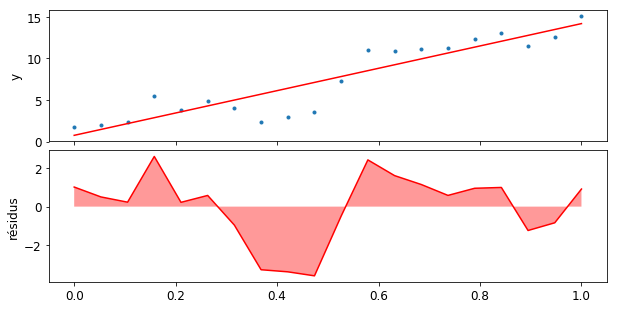

In [73]:
# <!-- collapse=True -->
fig, ax = plt.subplots(2, sharex=True, figsize=(10, 5));

ax[0].plot( X, Y, '.' );
ax[0].plot( X, Ymc, '-r' );
ax[0].set_ylabel('y');

ax[1].plot( X, R, '-r' );
ax[1].fill_between( X, R, alpha=0.4, facecolor='red');

ax[1].set_ylabel('résidus');

plt.subplots_adjust(wspace=0, hspace=.07);

On remarque déjà une certaine corrélation. On peut ausi tracer le residu au temps $t$ par rapport au temps $t-1$:

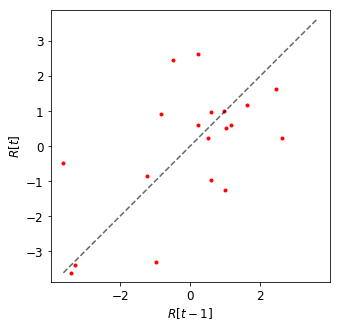

In [74]:
# <!-- collapse=True -->
plt.figure( figsize=(5, 5) )
plt.plot(  R[:-1], R[1:], '.r' )

m = np.max( np.abs(R) )
plt.plot(  [-m, m], [-m, m], '--k', alpha=.6 )

plt.axis('equal');
plt.xlabel('$R[ t-1 ]$'); plt.ylabel('$R[ t ]$');

L'indicateur naturel pour étudier une corrélation est le [coefficient de corrélation linéaire de Pearson](https://fr.wikipedia.org/wiki/Corr%C3%A9lation_%28statistiques%29#Coefficient_de_corr.C3.A9lation_lin.C3.A9aire_de_Bravais-Pearson )  (r). 

In [75]:
from scipy.stats import pearsonr

In [76]:
pearsonr( R[1:], R[:-1] )[0] # return r, p-value

0.59888301165389646

Une forte corrélation donne un coefficient proche de 1 et une absence de corrélation un coefficient proche de $0$.

Mais à quoi comparer cette valeur ? Peut-on fixer un seuil de décision si la régression est valide ou non ?

Il existe un test statistique pour cela: **Le test de Durbin-Watson** ([Wikipedia](https://en.wikipedia.org/wiki/Durbin–Watson_statistic)). Ce test est basé sur le coefficient de corrélation de Pearson de la dérivée première des résidus ($R(t) - R(t-1)$) ([Ref.](http://statisticalideas.blogspot.fr/2014/05/serial-correlation-techniques.html)).

** Problème:** des données issus de mesure réelles sont généralement fortement corrélées à haute fréquence... donnant un coefficient de Pearson proche de $1$ même pour une regression valide... To be continued...

## Est ce que la regression contre X est équivalente à celle sur Y ?

en fait non, ce n'est pas équivalent, parce que les erreurs sont calculées sur un axe particulier... ce n'est pas la mesure de la distance perpendiculairement à la droite (cad Régression orthogonale)...

Rq: l'expression de la pente $a$ n'est pas symétrique $x \leftrightarrow y$

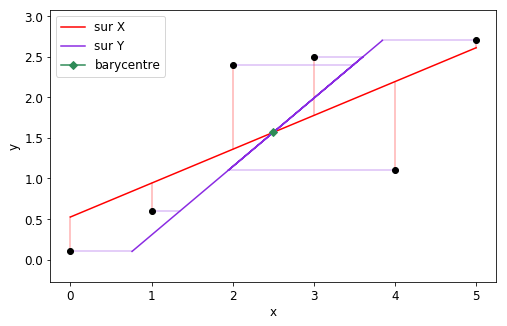

In [269]:
# <!-- collapse=True -->

X = np.array( [ 0, 1, 2, 3, 4, 5 ] )
Y = np.array( [ .1, .6, 2.4, 2.5, 1.1, 2.7 ] )

plt.figure( figsize=(8, 5) )

# Sur X
a, b = moindrescarres(X, Y)
plt.plot( X, a*X + b , 'r', label='sur X'  );
for x, y in zip(X, Y):
    plt.plot(  [x, x], [y, a*x+b] , '-r', alpha=.3  );
    
# Sur Y
a, b = moindrescarres(Y, X)
plt.plot(  a*Y + b, Y , 'blueviolet', label='sur Y'  );

for x, y in zip(X, Y):
    plt.plot(  [a*y + b, x], [y, y] , alpha=.3, color='blueviolet'  );

# Points
plt.plot( X, Y, "ok" );

plt.plot( X.mean(), Y.mean(), marker="D", color='seagreen', label='barycentre' );

plt.xlabel('x');plt.ylabel('y');
plt.axis('equal'); plt.legend(loc=2);

## Régression orthogonale 
voir https://fr.wikipedia.org/wiki/R%C3%A9gression_lin%C3%A9aire


et pour plus de détail: https://en.wikipedia.org/wiki/Total_least_squares

In [271]:
def moindrescarresXY(X, Y):
    xm, ym = np.mean( X ), np.mean( Y )
    
    C = (np.sum( (X-xm)**2 ) - np.sum( (Y-ym)**2 ))/2/np.sum( (Y-ym)*(X-xm) )
    a1 = -C + np.sqrt( C**2 + 1 )
    b1 = ym - a1*xm
 
    a2 = -C - np.sqrt( C**2 + 1 )
    b2 = ym - a2*xm
    
    return a1, b1, a2, b2

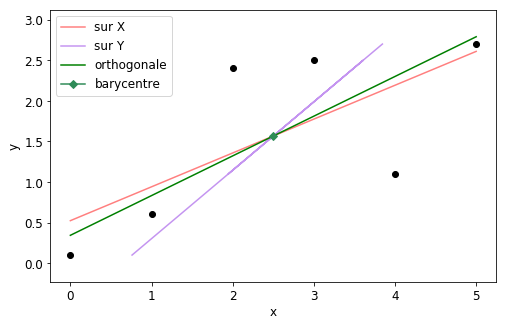

In [281]:
# <!-- collapse=True -->
plt.figure( figsize=(8, 5) )

# Sur X
a, b = moindrescarres(X, Y)
plt.plot( X, a*X + b , 'r', label='sur X' , alpha=.5 );
    
# Sur Y
a, b = moindrescarres(Y, X)
plt.plot(  a*Y + b, Y , 'blueviolet', label='sur Y' , alpha=.5  );

# Sur XY
a1, b1, a2, b2 = moindrescarresXY(X, Y)
plt.plot(  X, a1*X+b1 , 'green', label='orthogonale'  );
#plt.plot(  X, a2*X+b2 , 'green', label='sur XY'  );
   
#a1, b1, a2, b2 = moindrescarresXY(Y, X)
#plt.plot(  a1*Y+b1 , Y , 'blue', label='ortho'  );

# Points
plt.plot( X, Y, "ok" );

plt.plot( X.mean(), Y.mean(), marker="D", color='seagreen', label='barycentre' );

plt.xlabel('x');plt.ylabel('y');
plt.axis('equal'); plt.legend(loc=2);

## Regression linéraire multiple ... ?

$$
c_1.X + c_2.Y = 1 
$$
sous la forme matriciel:
$$
M*C = B
$$

In [258]:
from scipy.linalg import lstsq
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html#scipy.linalg.lstsq

In [285]:
M = np.array([X, Y]).transpose()
B = np.ones_like(X)

In [286]:
M, B

(array([[ 0. ,  0.1],
        [ 1. ,  0.6],
        [ 2. ,  2.4],
        [ 3. ,  2.5],
        [ 4. ,  1.1],
        [ 5. ,  2.7]]), array([1, 1, 1, 1, 1, 1]))

In [287]:
c, r, rank, s = lstsq(M, B)
print(c)

[ 0.11854225  0.2753304 ]


$$
c_1 x + c_2 y = 1
$$

$$
y = 1/c_2 - c_1/c_2 x
$$

In [288]:
Y_lstsq =  ((1-c[0]*X)/c[1] )#*Y.std() + Y.mean()

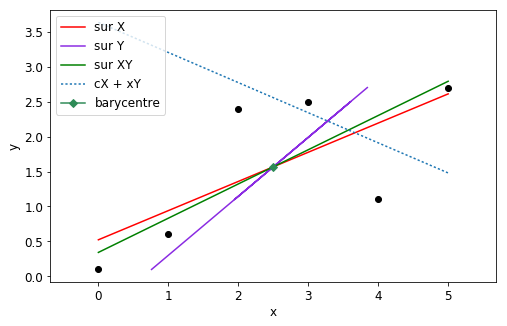

In [290]:
plt.figure( figsize=(8, 5) )

# Sur X
a, b = moindrescarres(X, Y)
plt.plot( X, a*X + b , 'r', label='sur X'  );
    
# Sur Y
a, b = moindrescarres(Y, X)
plt.plot(  a*Y + b, Y , 'blueviolet', label='sur Y'  );

# Sur XY
a1, b1, a2, b2 = moindrescarresXY(X, Y)
plt.plot(  X, a1*X+b1 , 'green', label='sur XY'  );
#plt.plot(  X, a2*X+b2 , 'green', label='sur XY'  );

plt.plot(  X, Y_lstsq , ':', label='cX + xY'  );

# Points
plt.plot( X, Y, "ok" );

plt.plot( X.mean(), Y.mean(), marker="D", color='seagreen', label='barycentre' );

plt.xlabel('x');plt.ylabel('y');
plt.axis('equal'); plt.legend(loc=2);

**To be continued...**